<div align="right">
<a href="/python/sample-notebooks/#Download-and-run-the-sample-notebooks" class="btn">Download the samples</a> <a href="//notebooks.esri.com/notebooks/samples/05_content_publishers/updating_features_in_a_feature_layer.ipynb" class="btn">Try it live</a>
</div>

# Updating features in a feature layer

As content publishers, you may be required to keep certain web layers up to date. As new data arrives, you may have to append new features, edit the modified or updated features etc. This sample explores a couple of different options
 
 - editing individual features as updated datasets arrive
 - overwriting feature layers altogether with updated datasets
 
Depending on the number of features that are updated and your workflow requirements you may adopt either or both kinds of update mechanisms.

Thus in this sample we talk about the following methods:

 - [Updating feature layer by editing individual features](#Updating-feature-layer-by-editing-individual-features)
  - [Publish the cities feature layer using the initial dataset](#Publish-the-cities-feature-layer-using-the-initial-dataset)
  - [Apply udpates from the second spreadsheet](#Apply-udpates-from-the-second-spreadsheet)
    - [Identifying existing features that need to be updated](#Identifying-existing-features-that-need-to-be-updated)
    - [Perform updates to the existing features](#Perform-updates-to-the-existing-features)
   

In [4]:
# Connect to the GIS
from arcgis.gis import GIS
from arcgis import features
from getpass import getpass #to accept passwords in an interactive fashion
import pandas as pd

In [2]:
password = getpass()
gis = GIS("https://www.arcgis.com",'arcgis_python',password)

········


## Updating feature layer by editing individual features

Let us consider a scenario where we need to update a feature layer containing the capital cities of the US. We have 3 csv datasets simulating an update workflow as described below:

 1. capitals_1.csv - contians the initial, incomplete dataset
 2. capitals_2.csv - contains additional points and updates to existing points, building on top of capitals_1.csv
 3. capitals_annex.csv - an alternate table containing additional attribute information
 
Our goal is to update the feature layer with each of these datasets doing the necessary edit operations.

### Publish the cities feature layer using the initial dataset

In [6]:
# read the initial csv
csv1 = 'data/updating_gis_content/capitals_1.csv'
cities_df_1 = pd.read_csv(csv1)
cities_df_1.head()

,City_ID,NAME,ST,CAPITAL,POP2000,POP2007,Longitude,Latitude
0,1,Honolulu,HI,State,371657,378587,-157.823436,21.305782
1,2,Juneau,AK,State,30711,31592,-134.511582,58.351418
2,3,Boise City,ID,State,185787,203529,-116.237655,43.613736
3,4,Olympia,WA,State,27514,45523,-122.893073,47.042418
4,5,Salem,OR,State,136924,152039,-123.029155,44.931109


In [7]:
# print the number of records in this csv
cities_df_1.shape

(19, 8)

As you can see, this dataset only contains 19 rows or 19 capital cities. It is not the complete dataset.

In [3]:
# add the initial csv file and publish that as a web layer
item_prop = {'title':'USA Capitals spreadsheet'}
csv_item = gis.content.add(item_properties=item_prop, data=csv1)
csv_item

<Item title:"USA Capitals spreadsheet" type:CSV owner:arcgis_python>

This spreadsheet has co-ordinates as `Latitude` and `Longitude` columns which will be used for geometries during publishing.

In [63]:
# publish the csv item into a feature layer
cities_item = csv_item.publish({'targetSR':4326}) #keep coordinates in Latitude and Longitude after publishing
cities_item

<Item title:"USA Capitals spreadsheet" type:Feature Service owner:arcgis_python>

<Item title:"USA Capitals" type:Feature Service owner:arcgis_python>
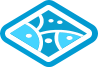

In [64]:
# update the item metadata
item_prop = {'title':'USA Capitals'}
cities_item.update(item_properties = item_prop, thumbnail='data/updating_gis_content/capital_cities.png')
cities_item

### Apply udpates from the second spreadsheet
The next set of updates have arrived and are stored in `capitals_2.csv`. We are told it contains corrections for the original set in addition to new features. We need to figure out which rows have changed, apply `update` operation on those, then apply `add` operation to new rows.

To start with, let us read the second csv file. Note in this sample, data is stored in csv. In reality it could be from your enterprise database or any other data source.

In [73]:
# read the second csv set
csv2 = 'data/updating_gis_content/capitals_2.csv'
cities_df_2 = pd.read_csv(csv2)
cities_df_2.head()

,City_ID,NAME,ST,CAPITAL,POP2000,POP2007,Longitude,Latitude
0,20,Baton Rouge,LA,State,227818,228810,-91.140227,30.458091
1,21,Helena,MT,State,25780,26007,-112.027027,46.595809
2,22,Bismarck,ND,State,55532,59344,-100.779000,46.813346
3,23,Pierre,SD,State,13876,14169,-100.336382,44.367964
4,24,St. Paul,MN,State,287151,291643,-93.114118,44.954364


In [12]:
# get the dimensions of this csv
cities_df_2.shape

(36, 8)

#### Identifying existing features that need to be updated

To identify features that need to be updated, let us read the attribute table of the published feature layer and compare that against the second csv. To read the attribute table, we perform a `query()` on the feature layer which returns us a `arcgis.feature.FeatureSet` object. Refer to the guide pages on [accessing features from feature layers](/python/guide/working-with-feature-layers-and-features/) to learn more about this.

Note, at this point, we could work with the `cities_df_1` dataframe we created from the original csv file. However in practice you may not always have the original dataset or your feature layer might have undergone edits after it was published. Hence we query the feature layer directly.

In [72]:
cities_flayer = cities_item.layers[0]
cities_fset = cities_flayer.query() #querying without any conditions returns all the features
cities_fset.df.head()

,CAPITAL,City_ID,Latitude,Longitude,NAME,POP2000,POP2007,ST,geometry.x,geometry.y
FID,,,,,,,,,,
1,State,1,21.305782,-157.823436,Honolulu,371657,378587,HI,-1.756882e+07,2.428377e+06
2,State,2,58.351418,-134.511582,Juneau,30711,31592,AK,-1.497376e+07,8.041505e+06
3,State,3,43.613736,-116.237655,Boise City,185787,203529,ID,-1.293952e+07,5.405860e+06
4,State,4,47.042418,-122.893073,Olympia,27514,45523,WA,-1.368039e+07,5.949001e+06
5,State,5,44.931109,-123.029155,Salem,136924,152039,OR,-1.369554e+07,5.610683e+06


The `City_ID` column is common between both the datasets. Next, let us perform an `inner` join with the table from feature layer as left and updated csv as right. Inner joins will yield those rows that are present in both tables. Learn more about [inner joins here](https://www.w3schools.com/sql/sql_join_inner.asp).

In [74]:
overlap_rows = pd.merge(left = cities_fset.df, right = cities_df_2, how='inner',
                       on = 'City_ID')
overlap_rows

,CAPITAL_x,City_ID,Latitude_x,Longitude_x,NAME_x,POP2000_x,POP2007_x,ST_x,geometry.x,geometry.y,NAME_y,ST_y,CAPITAL_y,POP2000_y,POP2007_y,Longitude_y,Latitude_y
0,State,4,47.042418,-122.893073,Olympia,27514,45523,WA,-1.368039e+07,5.949001e+06,Olympia,WA,State,42514,45523,-122.893073,47.042418
1,State,10,-41.145545,104.802046,Cheyenne,53011,54750,WY,1.166651e+07,-5.033833e+06,Cheyenne,WY,State,53011,54750,-104.802046,41.145545
2,State,13,35.482309,-97.534991,Oklahoma City,506132,552556,OKK,-1.085755e+07,4.229620e+06,Oklahoma City,OK,State,506132,552556,-97.534991,35.482309
3,State,16,41.590936,-93.620864,Des Moines,200682,201257,IA,-1.042183e+07,5.099899e+06,Des Moines,IA,State,198682,201257,-93.620864,41.590936


Thus, of 19 features in original and 36 features in second csv, 4 features are common. Inspecting the table, we find certains columns are updated, for instance, Cheyenne has its coordinates corrected, Oklahoma City has its state abbreviation corrected and similarly other cities have one of their attribute columns updated.

We could either update individual attribute values for these 4 features or update all attribute values with the latest csv. Below, we are performing the latter as it is simple and fast.

#### Perform updates to the existing features

In [75]:
features_for_update = [] #list containing corrected features
all_features = cities_fset.features

In [76]:
# inspect one of the features
all_features[0]

{"geometry": {"x": -17568824.5530287, "y": 2428377.3527147067}, "attributes": {"Longitude": -157.8234362, "City_ID": 1, "FID": 1, "ST": "HI", "CAPITAL": "State", "Latitude": 21.30578163, "NAME": "Honolulu", "POP2000": 371657, "POP2007": 378587}}

Note the X and Y geometry values are different from decimal degree coordinates present in Longitude and Latitude fields. To perform geometry edits, we need to project the coordinates to match that of the feature layer.

In [77]:
# get the spatial reference of the features since we need to update the geometry
cities_fset.spatial_reference

{'latestWkid': 3857, 'wkid': 102100}

In [106]:
from arcgis import geometry #use geometry module to project Long,Lat to X and Y
from copy import deepcopy

for city_id in overlap_rows['City_ID']:
    # get the feature to be updated
    original_feature = [f for f in all_features if f.attributes['City_ID'] == city_id][0]
    feature_to_be_updated = deepcopy(original_feature)
    
    print(str(original_feature))
    
    # get the matching row from csv
    matching_row = cities_df_2.where(cities_df_2.City_ID == city_id).dropna()
    
    #get geometries in the destination coordinate system
    input_geometry = {'y':float(matching_row['Latitude']),
                       'x':float(matching_row['Longitude'])}
    output_geometry = geometry.project(geometries = [input_geometry],
                                       in_sr = 4326, 
                                       out_sr = cities_fset.spatial_reference['latestWkid'],
                                      gis = gis)
    
    # assign the updated values
    feature_to_be_updated.geometry = output_geometry[0]
    feature_to_be_updated.attributes['Longitude'] = float(matching_row['Longitude'])
    feature_to_be_updated.attributes['City_ID'] = int(matching_row['City_ID'])
    feature_to_be_updated.attributes['ST'] = matching_row['ST'].values[0]
    feature_to_be_updated.attributes['CAPITAL'] = matching_row['CAPITAL'].values[0]
    feature_to_be_updated.attributes['Latitude'] = float(matching_row['Latitude'])
    feature_to_be_updated.attributes['NAME'] = matching_row['NAME'].values[0]
    feature_to_be_updated.attributes['POP2000'] = int(matching_row['POP2000'])
    feature_to_be_updated.attributes['POP2007'] = int(matching_row['POP2007'])
    
    #add this to the list of features to be updated
    features_for_update.append(feature_to_be_updated)
    
    print(str(feature_to_be_updated))
    print("========================================================================")

{"geometry": {"x": -13680394.2638528, "y": 5949000.54792491}, "attributes": {"Longitude": -122.8930726, "City_ID": 4, "FID": 4, "ST": "WA", "CAPITAL": "State", "Latitude": 47.04241817, "NAME": "Olympia", "POP2000": 27514, "POP2007": 45523}}
{"geometry": {"x": -13680394.2638528, "y": 5949000.54792491}, "attributes": {"Longitude": -122.8930726, "City_ID": 4, "FID": 4, "ST": "WA", "CAPITAL": "State", "NAME": "Olympia", "POP2007": 45523, "Latitude": 47.04241817, "POP2000": 42514}}
{"geometry": {"x": 11666510.350285437, "y": -5033833.302497153}, "attributes": {"Longitude": 104.8020456, "City_ID": 10, "FID": 10, "ST": "WY", "CAPITAL": "State", "Latitude": -41.14554516, "NAME": "Cheyenne", "POP2000": 53011, "POP2007": 54750}}
{"geometry": {"x": -11666510.350285435, "y": 5033833.302497153}, "attributes": {"Longitude": -104.80204559999999, "City_ID": 10, "FID": 10, "ST": "WY", "CAPITAL": "State", "NAME": "Cheyenne", "POP2007": 54750, "Latitude": 41.14554516, "POP2000": 53011}}
{"geometry": {"x"

We have constructed a list of features with updated values. We can use this list to perform updates on the feature layer.

In [143]:
features_for_update

[{"geometry": {"x": -13680394.2638528, "y": 5949000.54792491}, "attributes": {"Longitude": -122.8930726, "City_ID": 4, "FID": 4, "ST": "WA", "CAPITAL": "State", "NAME": "Olympia", "POP2007": 45523, "Latitude": 47.04241817, "POP2000": 42514}},
 {"geometry": {"x": -11666510.350285435, "y": 5033833.302497153}, "attributes": {"Longitude": -104.80204559999999, "City_ID": 10, "FID": 10, "ST": "WY", "CAPITAL": "State", "NAME": "Cheyenne", "POP2007": 54750, "Latitude": 41.14554516, "POP2000": 53011}},
 {"geometry": {"x": -10857545.54377847, "y": 4229619.674165817}, "attributes": {"Longitude": -97.5349911, "City_ID": 13, "FID": 13, "ST": "OK", "CAPITAL": "State", "NAME": "Oklahoma City", "POP2007": 552556, "Latitude": 35.48230867, "POP2000": 506132}},
 {"geometry": {"x": -10421826.864691716, "y": 5099899.263692743}, "attributes": {"Longitude": -93.62086361, "City_ID": 16, "FID": 16, "ST": "IA", "CAPITAL": "State", "NAME": "Des Moines", "POP2007": 201257, "Latitude": 41.59093617, "POP2000": 1986

To update the feature layer, call the `edit_features()` method of the `FeatureLayer` object and pass the list of features to the `updates` parameter:

In [109]:
cities_flayer.edit_features(updates= features_for_update)

{'addResults': [],
 'deleteResults': [],
 'updateResults': [{'globalId': None, 'objectId': 4, 'success': True},
  {'globalId': None, 'objectId': 10, 'success': True},
  {'globalId': None, 'objectId': 13, 'success': True},
  {'globalId': None, 'objectId': 16, 'success': True}]}

We have successfully applied corrections to those features which existed in the feature layer from the initial dataset. Next let us proceed to adding new features present in the second csv file.

#### Identifying new features that need to be added

In [123]:
#select those rows in the capitals_2.csv that do not overlap with those in capitals_1.csv
new_rows = cities_df_2[~cities_df_2['City_ID'].isin(overlap_rows['City_ID'])]
print(new_rows.shape)

(32, 8)


In [120]:
new_rows.head()

,City_ID,NAME,ST,CAPITAL,POP2000,POP2007,Longitude,Latitude
0,20,Baton Rouge,LA,State,227818,228810,-91.140227,30.458091
1,21,Helena,MT,State,25780,26007,-112.027027,46.595809
2,22,Bismarck,ND,State,55532,59344,-100.779000,46.813346
3,23,Pierre,SD,State,13876,14169,-100.336382,44.367964
4,24,St. Paul,MN,State,287151,291643,-93.114118,44.954364


#### Adding new features
Next, let us compose another list of features similar to earlier from the `new_rows` data frame.

In [136]:
features_to_be_added = []

# get a template feature object
template_feature = deepcopy(features_for_update[0])

# loop through each row and add to the list of features to be added
for row in new_rows.iterrows():
    new_feature = deepcopy(template_feature)
    
    #print
    print("Creating " + row[1]['NAME'])
    
    #get geometries in the destination coordinate system
    input_geometry = {'y':float(row[1]['Latitude']),
                       'x':float(row[1]['Longitude'])}
    output_geometry = geometry.project(geometries = [input_geometry],
                                       in_sr = 4326, 
                                       out_sr = cities_fset.spatial_reference['latestWkid'],
                                      gis = gis)
    
    # assign the updated values
    new_feature.geometry = output_geometry[0]
    new_feature.attributes['Longitude'] = float(row[1]['Longitude'])
    new_feature.attributes['City_ID'] = int(row[1]['City_ID'])
    new_feature.attributes['ST'] = row[1]['ST']
    new_feature.attributes['CAPITAL'] = row[1]['CAPITAL']
    new_feature.attributes['Latitude'] = float(row[1]['Latitude'])
    new_feature.attributes['NAME'] = row[1]['NAME']
    new_feature.attributes['POP2000'] = int(row[1]['POP2000'])
    new_feature.attributes['POP2007'] = int(row[1]['POP2007'])
    
    #add this to the list of features to be updated
    features_to_be_added.append(new_feature)

Creating Baton Rouge
Creating Helena
Creating Bismarck
Creating Pierre
Creating St. Paul
Creating Madison
Creating Lansing
Creating Augusta
Creating Montpelier
Creating Albany
Creating Boston
Creating Concord
Creating Tallahassee
Creating Jackson
Creating Nashville
Creating Montgomery
Creating Springfield
Creating Indianapolis
Creating Frankfort
Creating Columbus
Creating Charleston
Creating Atlanta
Creating Columbia
Creating Raleigh
Creating Richmond
Creating Harrisburg
Creating Trenton
Creating Dover
Creating Washington
Creating Annapolis
Creating Hartford
Creating Providence


In [141]:
# take a look at the first feature in addition list for a sample
features_to_be_added[0]

{"geometry": {"x": -10145683.671555312, "y": 3562570.141302621}, "attributes": {"Longitude": -91.14022709999999, "City_ID": 20, "FID": 4, "ST": "LA", "CAPITAL": "State", "NAME": "Baton Rouge", "POP2007": 228810, "Latitude": 30.45809113, "POP2000": 227818}}

To add new features to the feature layer, call the `edit_features()` method of the FeatureLayer object and pass the list of features to the `adds` parameter:

In [139]:
cities_flayer.edit_features(adds = features_to_be_added)

pass in features as dict or PropertyMap
Parameters not valid for edit_features


Thus we have successfully applied edits from 2nd csv file. Next we can proceed to apply edits from 3rd csv file.

### Apply edits from third spreadsheet
The next set of updates have arrived and are stored in capitals_annex.csv. We are told it contains additional columns for each of the features that we want to add to the feature layer.

To start with, let us read the third csv file. Note in this sample, data is stored in csv. In reality it could be from your enterprise database or any other data source.